# Eigenfaces for Recognition

## Defining the Facespace

First, let's import all we need and set some useful variables and functions.

In [1]:
import numpy as np
import numpy.linalg as la
from numpy.random import default_rng
from ipywidgets import interactive, fixed
from IPython.display import display
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from mpl_toolkits.axes_grid1 import ImageGrid

rng = default_rng()

N = 92
M = 112
NM = N * M
training_dir = "./att_faces/Training"

def get_path_to_img(id: int, number: int):
    return training_dir + "/s" + str(id) + "/" + str(number) + ".pgm"

def render_images(images: np.ndarray):
    fig = figure()
    
    nr_imgs = images.shape[1]
    
    rows = nr_imgs // 4 if nr_imgs % 4 == 0 else nr_imgs // 4 + 1
    
    grid = ImageGrid(fig, 111, 
                nrows_ncols=(rows, 4),
                axes_pad=0.1,  # pad between axes
                )
    for ax, im in zip(grid, images.T):
        ax.imshow(im.reshape(M, N), cmap = 'Greys_r')
        ax.axis('off')
        
def render_image(image):
    imshow(image, cmap = 'Greys_r')
    axis('off')

We will use the dataset from AT&T. Here's a sample of the faces we'll be using:

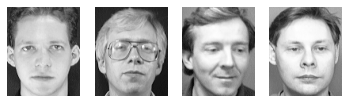

In [2]:
fig = figure()
for i in range(1, 5):
    path_to_img = get_path_to_img(i, i)
    fig.add_subplot(1, 4, i) 
    image = imread(path_to_img)
    render_image(image)

Every image has *M* rows and *N* columns. We shall collapse this matrix into a single vector with *N x M* rows.

Let's choose 16 random subjects from our data set and do the above.

In [3]:
training_set_ids = np.random.choice(range(1, 41), size=16, replace=False)
face_matrix = np.zeros(shape = (NM, 16), dtype = float)

for i, id in enumerate(np.nditer(training_set_ids)):
    path_to_img = get_path_to_img(id, 1)
    image = imread(path_to_img)
    image_vector = np.array(image).flatten()
    face_matrix[:, i] = image_vector

Let's take a look at the faces we chose:

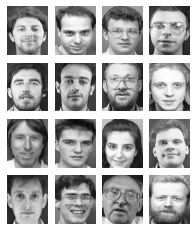

In [4]:
render_images(face_matrix)

The faces are now in a the `face_matrix`. Each column is a face. Now, let's calculate the **mean face**.

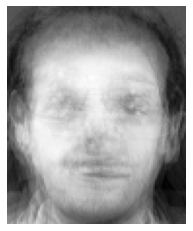

In [5]:
mean_face = np.zeros(shape = (NM,), dtype = float)

for face in face_matrix.T:
    mean_face += face
        
mean_face /= face_matrix.shape[1]

image = mean_face.reshape((M, N))
render_image(image)

Above you can see what the mean face looks like. Let's subtract it from the other faces, to **center the data**.

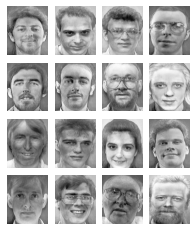

In [6]:
for i in range(0, face_matrix.shape[1]):
    face_matrix[:, i] -= mean_face

render_images(face_matrix)

And now, let's calculate our eigenfaces. They would, supposedly, be the eigenvectors of the covariance matrix of our `face_matrix`, ***A***, but we use a little trick: since the covariance matrix, ***S***, would be huge *((NM)^2 x (NM)^2)*, we will compute the eigenvectors of a smaller matrix. See the math below to understand why.

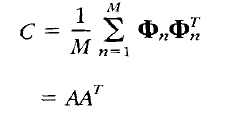

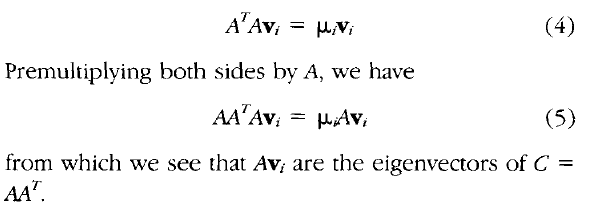

In [7]:
L_matrix = face_matrix.T @ face_matrix
eigenvalues, eigenvectors = la.eig(L_matrix)

eigenfaces = np.zeros(shape = face_matrix.shape, dtype = float)

for i in range(face_matrix.shape[1]):
    eigenfaces[:, i] = face_matrix.dot(eigenvectors[:, i])

Let's see what our (not so pretty) eigenfaces look like.

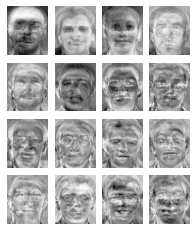

In [8]:
render_images(eigenfaces)

Now, let's get the top T eigenfaces:

In [9]:
def get_top_T_eigenfaces(evalues: np.ndarray, efaces: np.ndarray, T: int):
    top_indices = evalues.argsort()
    top_T_eigenfaces = np.zeros((NM, T), dtype = float)
    
    for i, e in reversed(list(enumerate(top_indices[:T]))):
        top_T_eigenfaces[:, i] = efaces[:, e] 
        
    render_images(top_T_eigenfaces)
        
    return top_T_eigenfaces

w = interactive(get_top_T_eigenfaces, evalues = fixed(eigenvalues), efaces = fixed(eigenfaces), T = (1, eigenfaces.shape[1]))

display(w)

interactive(children=(IntSlider(value=8, description='T', max=16, min=1), Output()), _dom_classes=('widget-int…

## Recognition

To recognize the face of a known individual, we need to create a ***face class*** — an average of the individual's known eigenface representations (the individual's face using the eigenfaces as base vectors).

After that, whenever we receive an input image, we shall project it onto *face space* and measure its distance to each of the face classes. We can also check if the input image is a face by measuring the distance from the original image to its projection in *face space*.

Let's create the *face classes* first.

In [10]:
basis_eigenfaces = w.result

def get_weights_vector(image: np.ndarray):
    return basis_eigenfaces.T @ image

def compute_face_class(class_index: int):
    face_class = np.zeros((basis_eigenfaces.T.shape[0],), dtype = float)
    for i in range(1, 10):
        path_to_img = get_path_to_img(class_index, i)
        image = imread(path_to_img)
        image_vector = np.array(image, dtype = float).flatten()
        image_vector -= mean_face
        face_class += get_weights_vector(image_vector)
    face_class /= 9
    return face_class

face_classes = {}
for i in training_set_ids:
    face_classes[i] = compute_face_class(i)

Now that we have our *face classes*, we can start receiving input images. But first, let's define functions to compute the distance to the *face classes* and to the *face space*.

In [11]:
def distance_to_face_class(kth_class: int, weights_vector: np.ndarray):
    if kth_class in face_classes:
        return la.norm(weights_vector - face_classes[kth_class])
    else:
        raise "Not a known class!"

def distance_to_face_space(mean_centered_face: np.ndarray, projected_face: np.ndarray):
    return la.norm(mean_centered_face - projected_face)

Let's set a threshold to use for the acceptable distance between a face class or the face space and the input image.

In [12]:
threshold = 0

def set_threshold(theta: float):
    global threshold
    threshold = theta

theta_w = interactive(set_threshold, theta = (0.0, 100.0))

display(theta_w)

interactive(children=(FloatSlider(value=50.0, description='theta'), Output()), _dom_classes=('widget-interact'…

Now, let's use a set of sixteen images: eight from the training set and eight outside the training set, and see the results!

In [16]:
rand_ids_not_in_training_set = rng.choice([x for x in range(1, 41) if x not in training_set_ids], size = 8, replace = False)
test_set_ids = np.concatenate((rand_ids_not_in_training_set, np.random.choice(training_set_ids, 8, replace = False)))

# Returns (kth_class, distance)
def get_closest_face_class(weights_vector: np.ndarray):
    ret_class = -1
    min_dist = float('inf')
    
    for k in face_classes:
        dist = distance_to_face_class(k, weights_vector)
        if (dist < min_dist):
            min_dist = dist
            ret_class = k
            
    return ret_class, min_dist

for i in test_set_ids:
    path_to_img = get_path_to_img(i, rng.integers(low = 1, high = 9))
    image = imread(path_to_img)
    image_vector = np.array(image, dtype = float).flatten()
    
    image_vector -= mean_face
    weights_vector = get_weights_vector(image_vector)
    projected_face = basis_eigenfaces @ weights_vector
    
    # Does it match a face class?
    
    (k, dist) = get_closest_face_class(weights_vector)
    dist_to_face_space = distance_to_face_space(image_vector, projected_face)
    
    print(dist_to_face_space)
    
    if dist < threshold and dist_to_face_space < threshold:
        print("Image {} is subject {}!".format(i, k))
    elif dist > threshold and dist_to_face_space < threshold:
        print("Image {} is an unknown subject!".format(i))
    else:
        print("Image {} is not a face!".format(i))

9574167901.984777
Image 18 is not a face!
13115249609.108473
Image 13 is not a face!
6111448396.131468
Image 35 is not a face!
8552386150.581042
Image 15 is not a face!
5356186533.8190775
Image 37 is not a face!
3542065461.797952
Image 31 is not a face!
7490115793.827373
Image 1 is not a face!
4977445168.99149
Image 21 is not a face!
6745560589.9977455
Image 26 is not a face!
4877107340.013844
Image 30 is not a face!
8090646221.650442
Image 20 is not a face!
8189954660.061319
Image 12 is not a face!
4723198524.907325
Image 34 is not a face!
5767638216.5030365
Image 7 is not a face!
6562941975.683016
Image 11 is not a face!
6116740157.819519
Image 36 is not a face!
